In [1]:
%load_ext autoreload
%autoreload 2

import yaml
import torch
import matplotlib.pyplot as plt

In [2]:
config_file = './configs/lego.yaml'
with open(config_file, 'r') as file:
    config = yaml.safe_load(file)

In [3]:
from utils.DataLoaderLego import DataLoaderLego

data_loader = DataLoaderLego(config['data'])

images, poses, focal = data_loader.getDataset('train')

In [4]:
device = 'cpu'
if torch.cuda.is_available():
    device = torch.cuda.current_device()
device = 'cpu'

In [5]:
from utils.Camera import Camera

cameras = []
H, W = images[0].shape[:2]

for i in range(images.shape[0]):
    cameras.append(Camera(H, W, poses[i], focal, device))

In [6]:
from utils.Renderer import Renderer

renderer = Renderer(config['renderer'])

9
9
torch.Size([100, 100, 100, 3]) torch.Size([100, 100, 100, 3]) torch.Size([100, 100, 100, 3])
torch.Size([100, 100, 100, 3, 3])
torch.Size([1000000, 3, 3])
Epoch: 0, Average loss: 1.9489305019378662, Secs per iter: 5.252993106842041
Test PSNR: 7.047874927520752
torch.Size([10000, 3])


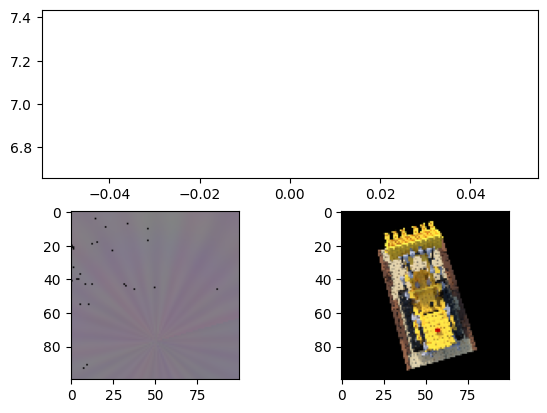

Epoch: 2, Average loss: 3.8217053413391113, Secs per iter: 10.7957444190979
Test PSNR: 7.0517497062683105
torch.Size([10000, 3])


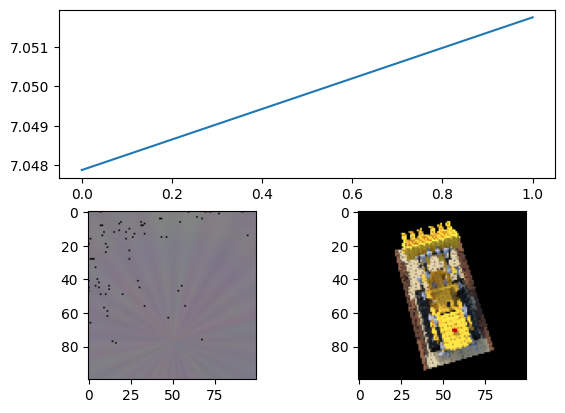

Epoch: 4, Average loss: 3.8748440742492676, Secs per iter: 10.772109627723694
Test PSNR: 7.043739318847656
torch.Size([10000, 3])


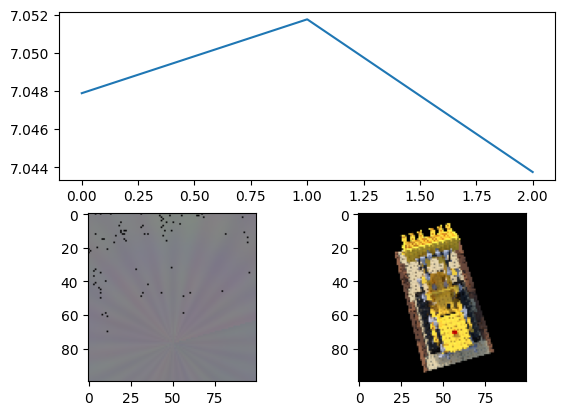

In [7]:
from models.Nerf import Nerf
from utils.TrainerNerf import TrainerNerf
import imageio.v3 as iio

test_img = "nerf_synthetic/lego/val/r_0.png"
test_img = iio.imread(test_img)[:,:,:3]
test_img = torch.tensor(test_img)
test_img = torch.nn.functional.interpolate(test_img[None,...].permute(
            0, 3, 1, 2), (100, 100), mode='bilinear', align_corners=False).permute(0, 2, 3, 1)[0]
test_img = test_img/255

test_pose = torch.tensor([
                [
                    -0.963964581489563,
                    -0.2611401677131653,
                    0.0507759265601635,
                    0.2046843022108078
                ],
                [
                    0.26603081822395325,
                    -0.9462433457374573,
                    0.18398693203926086,
                    0.7416750192642212
                ],
                [
                    7.450580596923828e-09,
                    0.1908649355173111,
                    0.9816163182258606,
                    3.957021951675415
                ],
                [
                    0.0,
                    0.0,
                    0.0,
                    1.0
                ]
            ])

model_sparse = Nerf(config['model']['L_xyz'],config['model']['L_dir'])
model_fine = Nerf(config['model']['L_xyz'],config['model']['L_dir'])
model = (model_sparse, model_fine)
trainer = TrainerNerf(model, device, images, cameras, renderer, config['trainer'])
trainer.train(test_img[None,...], test_pose[None,...], focal)